<a href="https://colab.research.google.com/github/Bidhan-hub/Convolutional-Neural-Network-CNN-using-PyTorch/blob/main/CNN_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
# Load MNIST Dataset & Convert Images to 4D Tensors

# Transform: Convert images to Tensor
transform = transforms.ToTensor()

# Download MNIST dataset
train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]


In [13]:
# Create DataLoaders (Batch Size = 10)       #####This code splits the MNIST data into small groups of 10 images, shuffles the training data for better learning, and keeps the test data in order for fair evaluation.
batch_size = 10

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [6]:
#  Define the Convolutional Neural Network
# Conv1: 1 → 6 filters, kernel=3, stride=1
# Conv2: 6 → 16 filters, kernel=3, stride=1        ###This CNN model uses two convolution and pooling layers to extract features from images, then flattens them and passes them through fully connected layers to classify the image into one of 10 digit classes.
# Pooling: kernel=2, stride=2
# Flatten → 120 → 84 → 10

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=3, stride=1
        )
        self.conv2 = nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=3, stride=1
        )

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # First convolution + pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Second convolution + pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [7]:
# Inspect One MNIST Image & Apply Convolutions
# This code takes one MNIST image, converts it into the correct 4D shape, and shows how its size changes step by step as it passes through each convolution and pooling layer of the CNN.
# Grab one image
sample_img, sample_label = train_data[0]
print("Original Image Shape:", sample_img.shape)

# Convert 3D → 4D
sample_img_4d = sample_img.unsqueeze(0)
print("Converted to 4D Shape:", sample_img_4d.shape)

# Initialize model
torch.manual_seed(41)
model = CNNModel()

# First convolution
conv1_out = model.conv1(sample_img_4d)
print("After Conv1:", conv1_out.shape)

# First pooling
pool1_out = F.max_pool2d(conv1_out, 2, 2)
print("After Pool1:", pool1_out.shape)

# Second convolution
conv2_out = model.conv2(pool1_out)
print("After Conv2:", conv2_out.shape)

# Second pooling
pool2_out = F.max_pool2d(conv2_out, 2, 2)
print("After Pool2:", pool2_out.shape)

Original Image Shape: torch.Size([1, 28, 28])
Converted to 4D Shape: torch.Size([1, 1, 28, 28])
After Conv1: torch.Size([1, 6, 26, 26])
After Pool1: torch.Size([1, 6, 13, 13])
After Conv2: torch.Size([1, 16, 11, 11])
After Pool2: torch.Size([1, 16, 5, 5])


In [8]:
# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Train & Test the CNN (Epochs = 5)
# This code trains the CNN for 5 epochs, updating the model weights using the training data, tracks the training and test loss and accuracy, evaluates the model on the test set without updating weights, and prints the results and total training time.
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Training
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred, 1)[1]
        trn_corr += (predicted == y_train).sum()

        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())

    # Testing (No Backpropagation)
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_val = model(X_test)
            loss = criterion(y_val, y_test)
            predicted = torch.max(y_val, 1)[1]
            tst_corr += (predicted == y_test).sum()

    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())

    print(f"Epoch {epoch+1}/{epochs} "
          f"Train Loss: {train_losses[-1]:.4f} "
          f"Test Loss: {test_losses[-1]:.4f}")

end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

Epoch 1/5 Train Loss: 0.0002 Test Loss: 0.0002
Epoch 2/5 Train Loss: 0.0300 Test Loss: 0.0000
Epoch 3/5 Train Loss: 0.0000 Test Loss: 0.0001
Epoch 4/5 Train Loss: 0.3199 Test Loss: 0.0007
Epoch 5/5 Train Loss: 0.0004 Test Loss: 0.0016
Training Time: 163.35 seconds


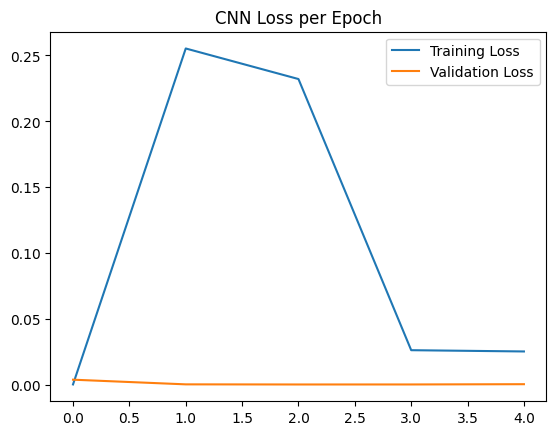

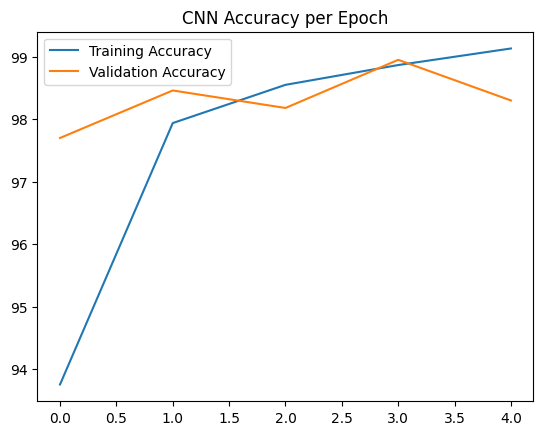

In [16]:
# Plot Loss & Accuracy
# This code creates graphs to visualize how the training and validation loss decrease and how the accuracy improves over each epoch, helping to understand the model’s learning progress.
# Loss graph
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()
plt.title("CNN Loss per Epoch")
plt.show()

# Accuracy graph
plt.plot(
    [x / len(train_data) * 100 for x in train_correct],
    label='Training Accuracy'
)
plt.plot(
    [x / len(test_data) * 100 for x in test_correct],
    label='Validation Accuracy'
)
plt.legend()
plt.title("CNN Accuracy per Epoch")
plt.show()

In [15]:
# Final Evaluation (Batch Size = 10,000)
#This code evaluates the CNN on the entire test dataset at once (batch size 10,000) without updating weights and calculates the final test accuracy as a percentage.
test_loader_large = DataLoader(
    test_data,
    batch_size=10000,
    shuffle=False
)

model.eval()
with torch.no_grad():
    for X_test, y_test in test_loader_large:
        y_pred = model(X_test)
        predicted = torch.max(y_pred, 1)[1]
        accuracy = (predicted == y_test).sum().item() / len(y_test) * 100

print(f"Final Test Accuracy: {accuracy:.2f}%")

Final Test Accuracy: 98.30%


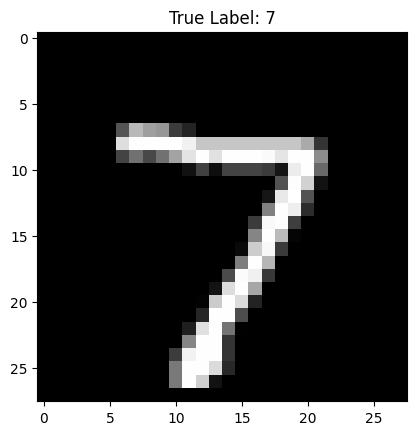

Predicted Label: 7


In [14]:
# Predict a Single Image & Display It
# This code takes one test image, displays it with its true label, reshapes it for the model, and predicts the digit using the trained CNN.
# Select one test image
img, label = test_data[0]

# Show the image
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"True Label: {label}")
plt.show()

# Prepare image for model
img = img.unsqueeze(0)

# Predict
model.eval()
with torch.no_grad():
    prediction = model(img)
    predicted_class = torch.argmax(prediction, 1)

print(f"Predicted Label: {predicted_class.item()}")